# Ticket-Price-Predictor
A machine learning predictor to help predict the price of a flight ticket.

Dataset: https://www.kaggle.com/datasets/dilwong/flightprices

Libraries used: Pandas, Numpy, Matplotlib, Seaborn, Sklearn

In [22]:
# Import the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Imported successfully")

Imported successfully


## Dataset Splitting

As our dataset is roughly 30GBs unzipped, it would take an impossibly long time to run this on any of my machines, so I decided to split the dataset into multiples of 50000 rows csv files (using an external program), then combine three randomly selected files into one csv file for a total for 150k rows.

Afterwards, I imported the 150k csv file into a pandas dataframe and used pandas's sample to sample the dataframe into a new dataframe with 8000 rows and saved into a new csv file to reimport later on.

In [ ]:
# Read the data
data = pd.read_csv('dataset/combine/combined-csv-files.csv')

# Randomised the data to 8000 rows (from the original 150000 rows)
data.sample(8000).to_csv('dataset/combine/combined-csv-files-sample.csv', index=False)

## Data Exploration

After importing the csv file into a pandas dataframe, I used the head() function to get a quick look at the data.

We can see that the dataset has a few columns prefixed with 'segments' and we can see from the sample rows inside these columns that they are separated by ||, we can safely **assume** that the more separators there are, the more segments the flight has. i.e. `segmentsDistance = 720||1745||338` means the flight has 3 segments, with the first segment being 720 miles, the second segment being 1745 miles and the third segment being 338 miles.


In [158]:
# Loading the 8000 rows dataset 

df = pd.read_csv('dataset/combine/combined-csv-files-sample.csv')

# Checking the data
df.head(6)



,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,535b0db761369fc82e6e20ffbf0c2961,2022-04-19,2022-06-06,LGA,LAX,QAA0KKEN,PT8H46M,0.0,False,False,...,1654550880||1654576560,2022-06-06T17:28:00.000-04:00||2022-06-06T21:3...,IAD||LAX,LGA||IAD,United||United,UA||UA,Embraer 175 (Enhanced Winglets)||Boeing 737-900,5880||19680,221||2295,coach||coach
1,ae2ee04df190b4a3b3d86de847860ecc,2022-04-22,2022-05-23,DEN,DTW,K0AIZNN1,PT6H33M,0.0,False,False,...,1653300420||1653312180,2022-05-23T06:07:00.000-04:00||2022-05-23T09:2...,CLT||DTW,DEN||CLT,American Airlines||American Airlines,AA||AA,Airbus A321||Boeing 737-800,11820||6480,1346||505,coach||coach
2,2efe95e89f76ee18169f68553e3037cf,2022-04-22,2022-05-22,DFW,BOS,H0AJZNN1,PT3H45M,0.0,False,False,...,1653253740,2022-05-22T17:09:00.000-04:00,BOS,DFW,American Airlines,AA,Airbus A321,13500,1556,coach
3,86c9e9c2064348f556b7f0abd7352c4f,2022-04-16,2022-04-21,IAD,DEN,LA3OA0BG,PT6H31M,0.0,True,False,...,1650567840||1650585480,2022-04-21T15:04:00.000-04:00||2022-04-21T17:5...,DTW||DEN,IAD||DTW,Delta||Delta,DL||DL,Canadair Regional Jet 900||Airbus A321,5820||11580,391||1142,coach||coach
4,b53afb250f4fa14bdf01fb8031b154df,2022-04-19,2022-06-10,JFK,CLT,SVAHZNN1,PT4H37M,0.0,False,False,...,1654900080||1654911420,2022-06-10T18:28:00.000-04:00||2022-06-10T21:3...,ORF||CLT,JFK||ORF,American Airlines||American Airlines,AA||AA,Embraer 175||Canadair Regional Jet 900,5280||4980,301||290,coach||coach
5,6ac0f132bc14123e3958779e19f8eb58,2022-04-19,2022-06-09,OAK,LGA,KAUOA0MQ,PT12H50M,0.0,False,False,...,1654790700||1654804440||1654831800,2022-06-09T09:05:00.000-07:00||2022-06-09T13:5...,LAX||DEN||LGA,OAK||LAX||DEN,Delta||United||United,DL||UA||UA,Embraer 175 (Enhanced Winglets)||Boeing 737-80...,5100||8640||14100,338||848||1621,coach||coach||coach


### Data Exploration: Graphs

We can see from the following few graphs that, depending on a number of factors, the price of a flight ticket can vary greatly.

**First Graph**: Average Price of Flights by Airline *(shows if the airline matters for the price of a ticket)*

**Second Graph**: Average Price of Flights by Flight Time *(shows the longer a flight is, the higher the price of a ticket)*

**Third Graph**: Average Price of Flights by Days Before Departure *(shows that the closer the departure date is to the current date, the higher the price of a ticket)*

**Fourth Graph**: Number of flights coming out of an Airport and how many are going to which airport

<AxesSubplot:title={'center':'Average Price of Flights by Airline'}, xlabel='airlineName'>

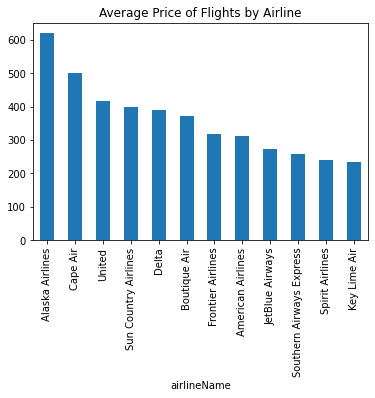

In [159]:
# This creates a new column which is the airline that operates the first segment of the flight, typically the airline that you book with in the first place.

df['airlineName'] = df['segmentsAirlineName'].str.rsplit('||', expand=True)[0]

# Creates a graph of the average price of flights by airline

df.groupby('airlineName')['totalFare'].mean().sort_values(ascending=False).plot(kind='bar', title='Average Price of Flights by Airline')

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Average Price of Flights by Flight Time'}, xlabel='travelTime'>

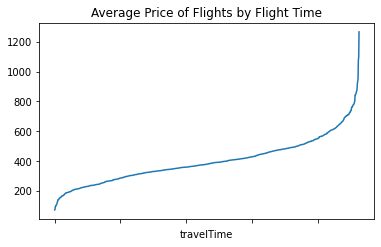

In [160]:
# Creates a new column, which is the converted travel duration from a string to a time delta for us to be able to easily manipulate the data later on

df['travelTime'] = pd.to_timedelta(df['travelDuration'].str.replace('PT', ''))

# Creates a graph of the average price of flights by flight time

df.groupby('travelTime')['totalFare'].mean().sort_values(ascending=True).plot(kind='line', title='Average Price of Flights by Flight Time')

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Average Price of Flights by Days Before Departure'}, xlabel='daysBeforeDeparture'>

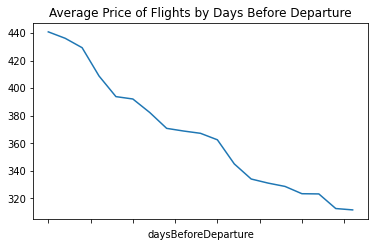

In [161]:
# Creates a new column 'daysBeforeDeparture' to show the number of days before the flight's departure date (flightDate - searchDate)

df['daysBeforeDeparture'] = pd.to_datetime(df['flightDate']) - pd.to_datetime(df['searchDate'])

# Creates a graph to show the correlation between days before departure and price

df.groupby('daysBeforeDeparture')['totalFare'].mean().sort_values(ascending=False).plot(kind='line', title='Average Price of Flights by Days Before Departure')

<AxesSubplot:title={'center':'Number of Flights by Airport'}, xlabel='startingAirport'>

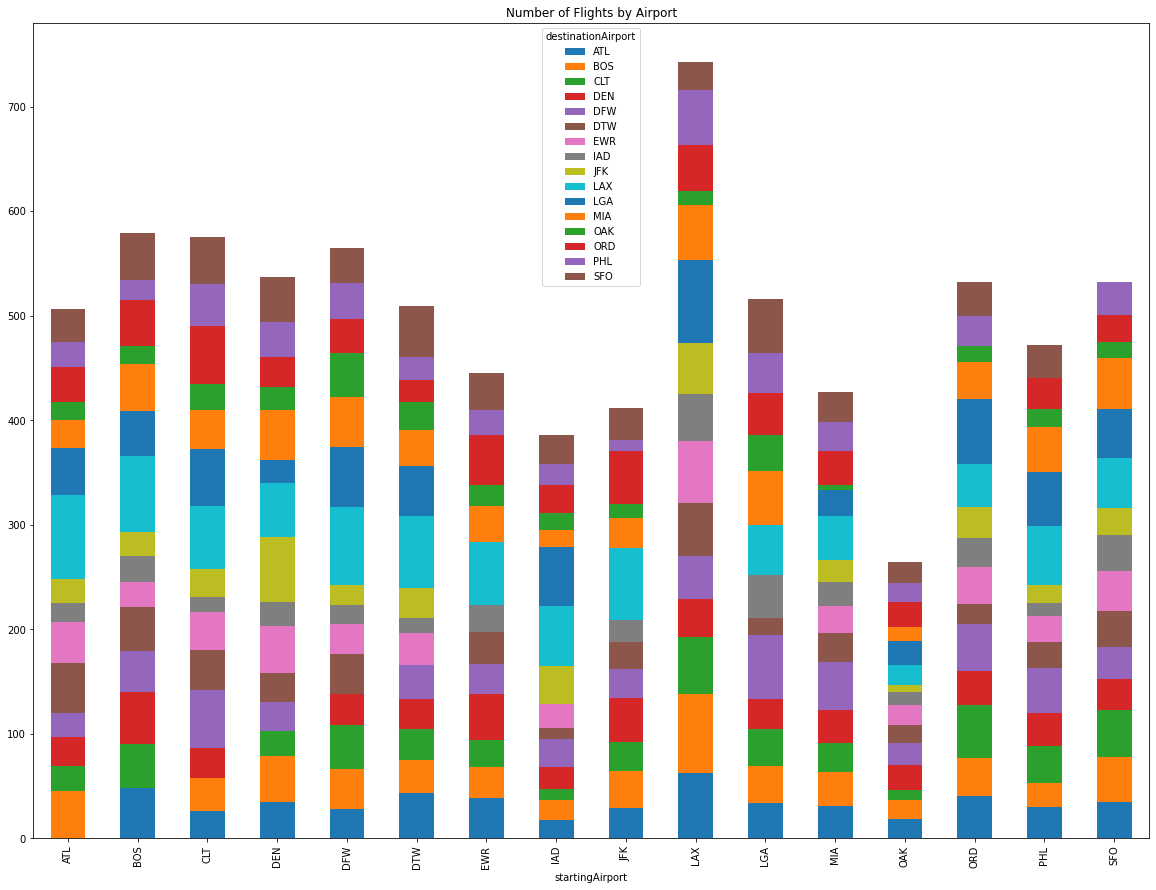

In [162]:
# Creates a stacked bar chart to show the number of flights coming out of an airport, and how many flights from that airport goes to another airport
df.groupby(['startingAirport', 'destinationAirport']).size().unstack().plot(kind='bar', stacked=True, title='Number of Flights by Airport', figsize=(20, 15))


## Data Pre-processing

We'll now need to pre-process the data to make it easier for the machine learning model to understand.

### Data Pre-processing: Removing Obsolete Columns

We created three columns earlier on to help us with our data exploration, we can now remove the original columns that we used to derive these new columns.
| New Column | Original Column | Reason |
| --- | --- | --- |
| `airlineName` | `segmentsAirlineName` | After we have extracted the first segment's airline name, we can remove the original column |
| `travelTime` | `travelDuration` | We have converted the original column's value into a more manipulatable format |
| `daysBeforeDeparture` | `flightDate` and `searchDate` | `daysBeforeDeparture` is an easier to use column than flightDate and searchDate |

So we can now remove these original columns from our dataframe.


In [163]:
# remove segmentsAirlineName, travelDuration, flightDate, searchDate
df = df.drop(['segmentsAirlineName', 'travelDuration', 'flightDate', 'searchDate'], axis=1)

# check that the columns have been removed correctly
df.head(6)

,legId,startingAirport,destinationAirport,fareBasisCode,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,...,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,airlineName,travelTime,daysBeforeDeparture
0,535b0db761369fc82e6e20ffbf0c2961,LGA,LAX,QAA0KKEN,0.0,False,False,False,340.47,389.61,...,IAD||LAX,LGA||IAD,UA||UA,Embraer 175 (Enhanced Winglets)||Boeing 737-900,5880||19680,221||2295,coach||coach,United,08:46:00,48 days
1,ae2ee04df190b4a3b3d86de847860ecc,DEN,DTW,K0AIZNN1,0.0,False,False,False,373.95,424.10,...,CLT||DTW,DEN||CLT,AA||AA,Airbus A321||Boeing 737-800,11820||6480,1346||505,coach||coach,American Airlines,06:33:00,31 days
2,2efe95e89f76ee18169f68553e3037cf,DFW,BOS,H0AJZNN1,0.0,False,False,True,485.58,536.60,...,BOS,DFW,AA,Airbus A321,13500,1556,coach,American Airlines,03:45:00,30 days
3,86c9e9c2064348f556b7f0abd7352c4f,IAD,DEN,LA3OA0BG,0.0,True,False,False,190.70,228.60,...,DTW||DEN,IAD||DTW,DL||DL,Canadair Regional Jet 900||Airbus A321,5820||11580,391||1142,coach||coach,Delta,06:31:00,5 days
4,b53afb250f4fa14bdf01fb8031b154df,JFK,CLT,SVAHZNN1,0.0,False,False,False,166.52,202.61,...,ORF||CLT,JFK||ORF,AA||AA,Embraer 175||Canadair Regional Jet 900,5280||4980,301||290,coach||coach,American Airlines,04:37:00,52 days
5,6ac0f132bc14123e3958779e19f8eb58,OAK,LGA,KAUOA0MQ,0.0,False,False,False,714.42,796.10,...,LAX||DEN||LGA,OAK||LAX||DEN,DL||UA||UA,Embraer 175 (Enhanced Winglets)||Boeing 737-80...,5100||8640||14100,338||848||1621,coach||coach||coach,Delta,12:50:00,51 days


### Data Pre-processing: Removing Unnecessary Columns

We can also remove some columns that we don't need for our machine learning model.
| Column | Reason |
| --- | --- |
| `legId` | We don't need this column as it is just a unique identifier for flight |
| `fareBasisCode` | We don't need this column as it is typically an unique identifier by airlines for their fares and would not help our model |
| `elapsedDays` | This column represents the days that has passed since the flight has *taken off*, as we're aiming to predict the price when booking a ticket, we can safely assume the flight has not taken off yet, and that the majority of the data's value is 0 |
| `baseFare` | This is the price of the ticket before any taxes and fees are added, we can remove this and assume that we'll be predicting prices that are after taxes and fees |
| `seatsRemaining` | This column represents the number of seats left on the flight, we can remove this column as we don't need it for our model |
| `segments---` | We can remove all the columns that are prefixed with `segments` as these columns are hard to manipulate and will only result in inconsistency in our model (except for `segmentsCabinCode`, as we'll extract it later) |


In [164]:
# remove the columns legId, fareBasisCode, elapsedDays, baseFare, seatsRemaining and all the columns with the word 'segments' in them
df = df.drop(['legId', 'fareBasisCode', 'elapsedDays', 'baseFare', 'seatsRemaining'], axis=1)
df = df.drop(['segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 'segmentsDistance'], axis=1)

# check that the columns have been removed correctly
df.head(6)

,startingAirport,destinationAirport,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,segmentsCabinCode,airlineName,travelTime,daysBeforeDeparture
0,LGA,LAX,False,False,False,389.61,2516.0,coach||coach,United,08:46:00,48 days
1,DEN,DTW,False,False,False,424.10,1851.0,coach||coach,American Airlines,06:33:00,31 days
2,DFW,BOS,False,False,True,536.60,1556.0,coach,American Airlines,03:45:00,30 days
3,IAD,DEN,True,False,False,228.60,1533.0,coach||coach,Delta,06:31:00,5 days
4,JFK,CLT,False,False,False,202.61,591.0,coach||coach,American Airlines,04:37:00,52 days
5,OAK,LGA,False,False,False,796.10,2807.0,coach||coach||coach,Delta,12:50:00,51 days


### Data Pre-processing: Removing Rows with Missing Values

We can also remove rows that have missing values, as we can't use them for our model.

First, we'll check which columns have rows of missing values and proceed to remove the rows with missing values in those columns.

We can see that `totalTravelDistance` has 479 rows with missing values inside our dataframe, we can fill these missing values with the mean of the `totalTravelDistance` of the same `startingAirport` and `destinationAirport`.

After that, we can check again and see that we've successfully filled in all the rows with missing values.

In [167]:
# Checks for missing values in the dataset
df.isnull().sum()

# Fills in the missing values rows with the mean totalDistance of the startingAirport and destinationAirport of the same from the missing value row
df['totalTravelDistance'] = df.groupby(['startingAirport', 'destinationAirport'])['totalTravelDistance'].transform(lambda x: x.fillna(x.mean()))

# Checks for missing values again
df.isnull().sum()

startingAirport        0
destinationAirport     0
isBasicEconomy         0
isRefundable           0
isNonStop              0
totalFare              0
totalTravelDistance    0
segmentsCabinCode      0
airlineName            0
travelTime             0
daysBeforeDeparture    0
dtype: int64

### Data Pre-processing: Feature Extraction

We can now extract the `segmentsCabinCode` column into a new column called `cabinCode` and remove the original column.

Currently it is in the format of `segmentsCabinCode = Y||Y||Y` (where `Y = cabinCode`), we can extract the first value and use it as our new column's value.

We can then see the amount of occurrences for each cabinCode inside the dataset. i.e. how many First Class, Business Class, Premium Economy Class and Economy Class flights are there.
(Note: Coach in the dataset refers to Economy Class)

We can see that there are `7967` Economy Class flights, `19` First Class flights, `11` Premium Economy Class flights and `3` Business Class flights.

Once done, we can safely remove the original `segmentsCabinCode` column.

In [172]:
# Extract cabinCode from segmentsCabinCode
df['cabinCode'] = df['segmentsCabinCode'].str.rsplit('||', expand=True)[0]

# Check that the cabinCode column has been created correctly
df.head(6)

# Check for the amount of occurrences of each cabinCode
df['cabinCode'].value_counts()

# Removes the segmentsCabinCode
df = df.drop(['segmentsCabinCode'], axis=1)

In [173]:
df.head()

,startingAirport,destinationAirport,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,airlineName,travelTime,daysBeforeDeparture,cabinCode
0,LGA,LAX,False,False,False,389.61,2516.0,United,08:46:00,48 days,coach
1,DEN,DTW,False,False,False,424.10,1851.0,American Airlines,06:33:00,31 days,coach
2,DFW,BOS,False,False,True,536.60,1556.0,American Airlines,03:45:00,30 days,coach
3,IAD,DEN,True,False,False,228.60,1533.0,Delta,06:31:00,5 days,coach
4,JFK,CLT,False,False,False,202.61,591.0,American Airlines,04:37:00,52 days,coach


### Data Pre-processing: Hot Encoding Categorical Columns

As we've cleaned our data, we can now hot encode our categorical columns, primarily `startingAirport`, `destinationAirport`, `airlineName` and `cabinCode`.

In [174]:
# Hot-encode the categorical columns
df = pd.get_dummies(df, columns=['startingAirport', 'destinationAirport', 'airlineName', 'cabinCode'])

# Check that the hot-encoding has been done correctly
df.head(6)

,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,travelTime,daysBeforeDeparture,startingAirport_ATL,startingAirport_BOS,startingAirport_CLT,...,airlineName_JetBlue Airways,airlineName_Key Lime Air,airlineName_Southern Airways Express,airlineName_Spirit Airlines,airlineName_Sun Country Airlines,airlineName_United,cabinCode_business,cabinCode_coach,cabinCode_first,cabinCode_premium coach
0,False,False,False,389.61,2516.0,08:46:00,48 days,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,False,False,False,424.10,1851.0,06:33:00,31 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,False,False,True,536.60,1556.0,03:45:00,30 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,True,False,False,228.60,1533.0,06:31:00,5 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,False,False,False,202.61,591.0,04:37:00,52 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,False,False,False,796.10,2807.0,12:50:00,51 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0
